# Технологии обработки больших данных

## Занятие 5. Машинное обучение в PySpark. Классификация 

1. Понятие энтропии Шеннона и поставновка задачи классификации
2. Классификация с помощью решающих деревьев в pyspark
3. Метрики качества
4. Работа со строковыми признаками
5. Домашнее задание 
  
**Рекомендованная литература:** 
- Learning Spark 2 edition
- [machinelearning.ru](http://www.machinelearning.ru/wiki/index.php?title=%D0%9A%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F)
- [Open Data Science Mlcourse ч.3](https://habr.com/ru/company/ods/blog/322534/)
- [метрики классификации](https://habr.com/ru/company/ods/blog/328372/)

## Установка pyspark в изолированой среде venv / conda env !

! pip install pyspark

In [1]:
! pip install pyspark

     |████████████████████████████████| 281.4 MB 32 kB/s 
     |████████████████████████████████| 198 kB 60.3 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=e96303bd9352d95f445590a696f9d65c2cde078be3af3acffc4190516313a5b3
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [2]:
import pyspark

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

## 1. Понятие энтропии Шеннона и поставновка задачи классификации

In [3]:
import numpy as np
import matplotlib.pyplot as plt

Пусть имеется выборка случайных чисел с равномерным распределением

In [4]:
y = np.random.randint(0, 2, size=(20))
print(y)

[0 1 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1]


**Этнтропия Шеннона** - мера упорядоченности выборки (системы).  

$$\Large S = - \sum_{i=0..N} p_i log_2 p_i$$

In [5]:
def entropy(y):
    unique, counts = np.unique(y, return_counts=True)
    N = y.size if type(y) == np.ndarray else len(y)
    p = counts / N
    log_p = np.log(p)
    print(f'p = {p}, log_p = {log_p}')
    S = - np.sum(p*log_p)
    return S

In [6]:
entropy(y)

p = [0.7 0.3], log_p = [-0.35667494 -1.2039728 ]


0.6108643020548935

Для полностью упорядоченной системы энтропия равна нулю

In [7]:
entropy(np.ones(20))

p = [1.], log_p = [0.]


-0.0

Чем больше возможных значений случайной величины, тем выше энтропия

In [8]:
y = np.random.randint(0, 11, size=(20))
print(y)

[ 7  9  8  0  3  0  8  0 10  3  3  2  1  2  3 10  2  3  0  9]


In [9]:
entropy(y)

p = [0.2  0.05 0.15 0.25 0.05 0.1  0.1  0.1 ], log_p = [-1.60943791 -2.99573227 -1.89711998 -1.38629436 -2.99573227 -2.30258509
 -2.30258509 -2.30258509]


1.9433779257532877

Пусть `y` не просто случайная величина, а функция от индекса `i` 

In [10]:
y = np.zeros(20)
y[:10] = 1
print(y)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Энтропия по-прежнему не равна 0, т.е. система не упорядочена

In [11]:
entropy(y)

p = [0.5 0.5], log_p = [-0.69314718 -0.69314718]


0.6931471805599453

Однако, применив правило для разделения выборки на две части `i < 10`, получим две полностью упорядоченные выборки с нулевой энтропией

In [12]:
y1, y2 = [], []

for i in range(len(y)):
    if i < 10:
        y1.append(y[i])
    else:
        y2.append(y[i])
        
print(entropy(y1), entropy(y2))

p = [1.], log_p = [0.]
p = [1.], log_p = [0.]
-0.0 -0.0


В том случае, если `y` зависит от нескольких переменных, суть задачи не меняется: нужно найти такое правило, которое позволит разделить неупорядоченную выборку на несколько более упорядоченных.

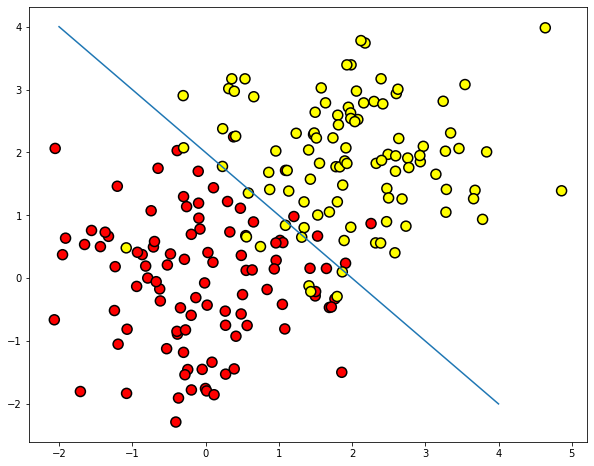

In [13]:
# первый класс
np.random.seed(7)
train_data = np.random.normal(size=(100, 2))
train_labels = np.zeros(100)

# добавляем второй класс
train_data = np.r_[train_data, np.random.normal(size=(100, 2), loc=2)]
train_labels = np.r_[train_labels, np.ones(100)]

plt.rcParams['figure.figsize'] = (10,8)
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
cmap='autumn', edgecolors='black', linewidth=1.5);
plt.plot(range(-2,5), range(4,-3,-1));

Проблема решающих деревьев в том, что разделяющая граница может строится только по одному признаку за раз.  
Решение - использовать деревья большой глубины.

## 2. Классификация с помощью решающих деревьев в pyspark

**Columns**  

Age - возраст (numeric)  
Sex - пол (text: male, female)  
Job - уровень рабочей квалификации (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)  
Housing - жилье (text: own, rent, or free)  
Saving accounts - накопления (text - little, moderate, quite rich, rich)  
Checking account - средние траты (numeric, in DM - Deutsch Mark)  
Credit amount - размер кредита (numeric, in DM)  
Duration - срок кредита (numeric, in month)  
Purpose - цель кредита (text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)  
Risk - признак невозврата кредита

In [17]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer, VectorAssembler
from pyspark.sql.functions import col, when

data_path = 'sample_data/german_credit_data.csv'

In [18]:
df = spark.read.format('csv').\
        options(header='true', inferschema='true').load(data_path,header=True)

# Добавляем числовую переменную у с помощью фунций when, col
df = df.withColumn('y', when(col('Risk')=='bad', 1).otherwise(0))

In [19]:
df.show(5)

+---+---+------+---+-------+---------------+----------------+-------------+--------+-------------------+----+---+
|_c0|Age|   Sex|Job|Housing|Saving accounts|Checking account|Credit amount|Duration|            Purpose|Risk|  y|
+---+---+------+---+-------+---------------+----------------+-------------+--------+-------------------+----+---+
|  0| 67|  male|  2|    own|             NA|          little|         1169|       6|           radio/TV|good|  0|
|  1| 22|female|  2|    own|         little|        moderate|         5951|      48|           radio/TV| bad|  1|
|  2| 49|  male|  1|    own|         little|              NA|         2096|      12|          education|good|  0|
|  3| 45|  male|  2|   free|         little|          little|         7882|      42|furniture/equipment|good|  0|
|  4| 53|  male|  2|   free|         little|          little|         4870|      24|                car| bad|  1|
+---+---+------+---+-------+---------------+----------------+-------------+--------+----

In [20]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Job: integer (nullable = true)
 |-- Housing: string (nullable = true)
 |-- Saving accounts: string (nullable = true)
 |-- Checking account: string (nullable = true)
 |-- Credit amount: integer (nullable = true)
 |-- Duration: integer (nullable = true)
 |-- Purpose: string (nullable = true)
 |-- Risk: string (nullable = true)
 |-- y: integer (nullable = false)



Для начала попробуем предсказывать риск невозврата с помощью двух переменных - возраста заемщика и размера кредита.

In [21]:
feature_vec = VectorAssembler(inputCols=['Age', 'Credit amount'], outputCol='Features')
vec_df = feature_vec.transform(df)
vec_df.select('Age', 'Credit amount', 'Features', 'Risk', 'y').show(5)

+---+-------------+-------------+----+---+
|Age|Credit amount|     Features|Risk|  y|
+---+-------------+-------------+----+---+
| 67|         1169|[67.0,1169.0]|good|  0|
| 22|         5951|[22.0,5951.0]| bad|  1|
| 49|         2096|[49.0,2096.0]|good|  0|
| 45|         7882|[45.0,7882.0]|good|  0|
| 53|         4870|[53.0,4870.0]| bad|  1|
+---+-------------+-------------+----+---+
only showing top 5 rows



In [22]:
trainDF, testDF = vec_df.randomSplit([.8, .2], seed=42)

tree_cls = DecisionTreeClassifier(labelCol="y", featuresCol="Features")
model = tree_cls.fit(trainDF)

predDF = model.transform(testDF)
predDF.select('Age', 'Credit amount', 'y', 'prediction').show()

+---+-------------+---+----------+
|Age|Credit amount|  y|prediction|
+---+-------------+---+----------+
| 49|         2096|  0|       0.0|
| 53|         2835|  0|       0.0|
| 61|         3059|  0|       0.0|
| 60|         1199|  1|       0.0|
| 31|         3430|  0|       0.0|
| 44|         1804|  0|       0.0|
| 63|         6836|  1|       0.0|
| 25|         4746|  1|       0.0|
| 35|         1393|  0|       0.0|
| 39|         2299|  0|       0.0|
| 23|         1352|  0|       0.0|
| 28|         2073|  0|       0.0|
| 30|         5965|  0|       0.0|
| 26|          783|  0|       0.0|
| 61|         1953|  1|       0.0|
| 25|         2394|  0|       0.0|
| 51|         4771|  0|       1.0|
| 41|         1469|  0|       0.0|
| 28|         6260|  0|       0.0|
| 30|         7174|  1|       0.0|
+---+-------------+---+----------+
only showing top 20 rows



## 3. Метрики качества классификации

In [23]:
correct = predDF['y'] == predDF['prediction']

**Accuracy** - доля правильных ответов. К сожалению, эта метрика бесполезна в задачах с неравными классами.

In [24]:
predDF.filter(correct).count() / predDF.count()

0.654320987654321

Если всегда предсказывать нули, то получим большее значение Accuracy

In [25]:
predDF.filter(predDF.y == 0).count() / predDF.count()

0.6604938271604939

Для оценки качества работы алгоритма на каждом из классов по отдельности используются метрики precision (точность) и recall (полнота).

$$\large precision = \frac{TP}{TP + FP}$$  


$$\large recall = \frac{TP}{TP + FN}$$

In [26]:
predDF = predDF.withColumn('confuse', 
                           when( (predDF.y == 1) & (predDF.prediction == 1.0), 'TP' ).\
                           when( (predDF.y == 0) & (predDF.prediction == 0.0), 'TN' ).\
                           when( (predDF.y == 0) & (predDF.prediction == 1.0), 'FP' ).\
                           when( (predDF.y == 1) & (predDF.prediction == 0.0), 'FN' )\
                            .otherwise('None') 
                          )
predDF.select('Age', 'Credit amount', 'y', 'prediction', 'confuse').show()

+---+-------------+---+----------+-------+
|Age|Credit amount|  y|prediction|confuse|
+---+-------------+---+----------+-------+
| 49|         2096|  0|       0.0|     TN|
| 53|         2835|  0|       0.0|     TN|
| 61|         3059|  0|       0.0|     TN|
| 60|         1199|  1|       0.0|     FN|
| 31|         3430|  0|       0.0|     TN|
| 44|         1804|  0|       0.0|     TN|
| 63|         6836|  1|       0.0|     FN|
| 25|         4746|  1|       0.0|     FN|
| 35|         1393|  0|       0.0|     TN|
| 39|         2299|  0|       0.0|     TN|
| 23|         1352|  0|       0.0|     TN|
| 28|         2073|  0|       0.0|     TN|
| 30|         5965|  0|       0.0|     TN|
| 26|          783|  0|       0.0|     TN|
| 61|         1953|  1|       0.0|     FN|
| 25|         2394|  0|       0.0|     TN|
| 51|         4771|  0|       1.0|     FP|
| 41|         1469|  0|       0.0|     TN|
| 28|         6260|  0|       0.0|     TN|
| 30|         7174|  1|       0.0|     FN|
+---+------

In [27]:
def print_metrics(predDF):
    predDF = predDF.withColumn('confuse', 
                               when( (predDF.y == 1) & (predDF.prediction == 1.0), 'TP' ).\
                               when( (predDF.y == 0) & (predDF.prediction == 0.0), 'TN' ).\
                               when( (predDF.y == 0) & (predDF.prediction == 1.0), 'FP' ).\
                               when( (predDF.y == 1) & (predDF.prediction == 0.0), 'FN' )\
                                .otherwise('None') 
                              )
    print('Precision: ', predDF.filter(predDF.confuse == 'TP').count() / (
        predDF.filter(predDF.confuse == 'TP').count() + predDF.filter(predDF.confuse == 'FP').count() ))

    print('Recall: ',  predDF.filter(predDF.confuse == 'TP').count() / (
        predDF.filter(predDF.confuse == 'TP').count() + predDF.filter(predDF.confuse == 'FN').count() ))

In [28]:
print_metrics(predDF)

Precision:  0.42857142857142855
Recall:  0.05454545454545454


## 4. Feature engineering

In [29]:
# String to number features
df = df.withColumn('Savings', 
                   when(col('Saving accounts')=='rich', 4).\
                   when(col('Saving accounts')=='quite rich', 3).\
                   when(col('Saving accounts')=='moderate', 2).\
                   when(col('Saving accounts')=='little', 1).\
                   otherwise(0))

# One hot encoding
df = df.withColumn('Purpose_1', 
                   when(col('Purpose')=='radio/TV', 1).\
                   otherwise(0))

inputCols = ['Age', 'Credit amount', 'Savings', 'Purpose_1']

feature_vec = VectorAssembler(inputCols=inputCols, outputCol='Features')
tree_cls = DecisionTreeClassifier(labelCol="y", featuresCol="Features", maxDepth=5)


In [30]:
vec_df = feature_vec.transform(df)
trainDF, testDF = vec_df.randomSplit([.8, .2], seed=42)
model = tree_cls.fit(trainDF)
predDF = model.transform(testDF)
print_metrics(predDF)

Precision:  0.48
Recall:  0.21818181818181817


## 5. Домашнее задание 

С помощью выбора признаков и максимальной глубины деревьев добейтесь **Precision > 0.5 and Recall > 0.5**

In [96]:
df = spark.read.format('csv').\
        options(header='true', inferschema='true').load(data_path,header=True)
df = df.withColumn('y', when(col('Risk')=='bad', 1).otherwise(0))
df.show(3)

+---+---+------+---+-------+---------------+----------------+-------------+--------+---------+----+---+
|_c0|Age|   Sex|Job|Housing|Saving accounts|Checking account|Credit amount|Duration|  Purpose|Risk|  y|
+---+---+------+---+-------+---------------+----------------+-------------+--------+---------+----+---+
|  0| 67|  male|  2|    own|             NA|          little|         1169|       6| radio/TV|good|  0|
|  1| 22|female|  2|    own|         little|        moderate|         5951|      48| radio/TV| bad|  1|
|  2| 49|  male|  1|    own|         little|              NA|         2096|      12|education|good|  0|
+---+---+------+---+-------+---------------+----------------+-------------+--------+---------+----+---+
only showing top 3 rows



In [97]:
df = df.withColumn('Savings_num', 
                   when(col('Saving accounts')=='rich', 4).\
                   when(col('Saving accounts')=='quite rich', 3).\
                   when(col('Saving accounts')=='moderate', 2).\
                   when(col('Saving accounts')=='little', 1).\
                   otherwise(0))

df = df.withColumn('House_num', 
                   when(col('Housing')=='own', 3).\
                   when(col('Housing')=='rent', 2).\
                   when(col('Housing')=='free', 1).\
                   otherwise(0))

df = df.withColumn('Checkings_num', 
                   when(col('Checking account')=='rich', 4).\
                   when(col('Checking account')=='NA', 3).\
                   when(col('Checking account')=='moderate', 2).\
                   when(col('Checking account')=='little', 1).\
                   otherwise(0))


In [98]:
trainDF, testDF = df.randomSplit([.8, .2], seed=42)

In [99]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline

oheCols = ['Purpose', 'Sex']

indexOutputCols = ['Purpose_Index', 'Sex_Index']
oheOutputCols = ["Purpose_OHE"]

stringIndexer = StringIndexer(inputCols=oheCols,
        outputCols=indexOutputCols,
        handleInvalid="skip")

oheEncoder = OneHotEncoder(inputCols=['Purpose_Index'],
                           outputCols=oheOutputCols)


In [103]:
numeric_cols = ['Age', 'Job', 'Credit amount', 'Duration', 'Savings_num', 
                'House_num', 'Checkings_num', 'Sex_Index']

inputCols = oheOutputCols + numeric_cols

feature_vec = VectorAssembler(inputCols=inputCols, outputCol='Features')
tree_cls = DecisionTreeClassifier(labelCol="y", featuresCol="Features", maxDepth=9)

In [109]:
for d in range(15, 20):
tree_cls = DecisionTreeClassifier(labelCol="y", featuresCol="Features", maxDepth=d)
  pipeline = Pipeline(stages=[stringIndexer, oheEncoder, feature_vec, tree_cls])
  pipelineModel = pipeline.fit(trainDF)
  predDF = pipelineModel.transform(testDF)
  print(f'Depth = {d}')
  print_metrics(predDF)

Depth = 15
Precision:  0.5882352941176471
Recall:  0.5454545454545454
Depth = 16
Precision:  0.58
Recall:  0.5272727272727272
Depth = 17
Precision:  0.5882352941176471
Recall:  0.5454545454545454
Depth = 18
Precision:  0.58
Recall:  0.5272727272727272
Depth = 19
Precision:  0.5869565217391305
Recall:  0.4909090909090909


In [105]:
print_metrics(predDF)

Precision:  0.6458333333333334
Recall:  0.5636363636363636
